# Amazon Fine Food Reviews Dataset
OBJECTIVE:- Our task here is to determine when a person writes review is positive or
            negative

What we are given here is a data which is table of reviews of fine foods given by the 
customers in Amazon online shopping.
this data consists of 10 features and product review of some product 
given by some customer.
Data was taken from kaggle and files downloaded was:-
 * database.sqlite
 * hashes.txt
 * Reviews.csv

So, first we read the sqlite file and see the contents in it.

In [2]:
import sqlite3
import pandas as pd
import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
def cleanhtml(sentance): #substitute expression contained in <> with ' '
    cleaned= re.sub(re.compile('<.*?>'),' ',sentance)
    return cleaned
#function for removing punctuations chars
def cleanpunc(sentance):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentance)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentance)
    return cleaned
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer as sno
nltk.download('stopwords')
setofstopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Ankit Kumar
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#for that we will import sqlite3 and store extraction in dataFrame of pandas
#making connection with sql database and reading
connection= sqlite3.connect('database.sqlite')
dataf= pd.read_sql_query('''
SELECT * FROM Reviews
''',connection)
dataf.shape

(568454, 10)

In [2]:
dataf.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

So, our data is having 570k data points each resembling reviews. All data
points have 10 features(columns):-
* Id (index number)
* ProdictId
* UserId
* ProfileName (of user)
* HelpfulnessNumerator (no of people found this review helpful)
* HelpfulnessDenominator (no of people found thes review helpful or not)
* Score (or we say it rating of product between 1 to 5)
* Time (when it was posted)
* Summary 
* Text (paragraph written by reviewer)

Our next step will be to transform score data to positive(4-5) or negative(1-2)
and discard score 3 type datapoints

In [3]:
#fetching data from database
dataf= pd.read_sql_query('''
SELECT * FROM Reviews
WHERE Score != 3
''',connection)
#changing score to positive negative 
#actualy this is the best way note it. for if else will take ages for this
#to work
dataf['Score']=dataf['Score'].map(lambda x:'Positive' if x>3 else 'Negative')
dataf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
print('no of products = ',len(set(dataf['ProductId'])))

no of products =  72005


In [10]:
dataf.shape

(525814, 10)

# Data cleaning
* Removing duplicate data (deduplication)
* intution cleaning- helpfulnessnum and helpfulnessden

In [4]:
#deduplication
sorteddata= dataf.sort_values('ProductId',axis=0)
finaldata= sorteddata.drop_duplicates(subset={'UserId','ProfileName',\
        'Time','Text'}, keep='first',inplace=False)
finaldata.shape

(364173, 10)

In [9]:
#helpfulness
finaldata= finaldata[finaldata['HelpfulnessNumerator'] <= finaldata['HelpfulnessDenominator']]
finaldata.shape

(364171, 10)

The main property to classify a review as positive or negative is the text feature.
To train a model or to visualise or analyse the data the best way to do it to transform
text to a vector. But before we convert text to vector we must filter, clean and massage
our text.
# Text-Preprocessing
Till now we have cleaned data frame now text present in it.
common text prepocessing are:-
* Removal of html tags
* Removal of punctuations or limited set of characters like .,#@etc
* Removal of Non-english words (alnum)
* Removal of words with length less than 3 (research says they contain no meaning)
* convertion of all cases to lower case
* removal of stop-words
* Snowball stemming of words(better than potter steming)

In [10]:
#defining functions
#function for removing html(tags) like <br\>

#stopwords set and snowstemmer stemming

snowstem= sno('english')
print(setofstopwords)
print(snowstem.stem('beautiful'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
{'ll', 'why', 're', "it's", "mightn't", 'myself', 'above', 'ain', 'of', 'which', 'under', 'shan', 'the', 'ours', 'yourself', 'up', 'now', 'further', 'so', 'been', 'itself', "haven't", 'when', 'mustn', 've', 'm', 'ourselves', 'yourselves', 'was', 'having', 'does', 'how', "doesn't", 'just', 'once', 'our', 'most', 'your', 'to', 's', 'than', 'they', 'is', 'again', 'before', 'who', 'o', 'what', "needn't", 'his', "won't", 'not', "should've", 'i', 'same', 'that', 'for', 'there', 'into', 'themselves', 'out', 'theirs', 'down', 'each', "aren't", 'did', 'other', 'their', 'won', 'didn', 'its', 'being', "didn't", 'were', "shouldn't", 'are', 'own', 'hers', "don't", 'between', 'hasn', 'through', 'against', 'have', 'we', 'those', 'couldn', 'shouldn', 'him', 't', 'yours', 'where', 'no', 'can', 'needn', 'from', 'will', 'me', 'wasn', 'over', 'himself', 'am', "hadn't", 'had', 'be', 'ma', 'these', 'mightn'

In [11]:
#saving till now
connection= sqlite3.connect('cleanedtable.sqlite')
finaldata.to_sql('Reviews2',connection)
#a=pd.read_sql_query('''
#SELECT * FROM Reviews2
#''',connection)
#a.head(2)

In [15]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for sent in finaldata['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here 
        # because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" 
        # as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in setofstopwords):
                    s=(snowstem.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(finaldata['Score'].values)[i] =='Positive':
                        all_positive_words.append(s)
                    if(finaldata['Score'].values)[i] =='Negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)

# storing data till now
finaldata['CleanedText']=final_string 
#adding a column of CleanedText which displays the data after pre-processing of the review 
finaldata['CleanedText']=finaldata['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final1.sqlite')
c=conn.cursor()
conn.text_factory = str
finaldata.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
        index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [16]:
finaldata['CleanedText'].head(3)

138706    witti littl book make son laugh loud recit car...
138688    grew read sendak book watch realli rosi movi i...
138689    fun way children learn month learn poem throug...
Name: CleanedText, dtype: object

# Text to vector using Bow(2-gram)
As informaion like 'not' will be lost we will not remove stopwords. and nearby relation of text will be mantained 

In [24]:
positivedata=finaldata[finaldata['Score']=='Positive'].sample(n=2000)
negativedata=finaldata[finaldata['Score']=='Negative'].sample(n=2000)
finalsampledata=pd.concat([positivedata,negativedata])
scoresampledata=finalsampledata['Score'].copy()
scoresampledata.shape

(4000,)

In [18]:
final_bigram_count=CountVectorizer(ngram_range=(1,2))\
     .fit_transform(finalsampledata['CleanedText'].values)

In [19]:
final_bigram_count.shape

(4000, 113843)

In [20]:
std_data= StandardScaler(with_mean=False).fit_transform(final_bigram_count)
std_data.shape

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4000, 113843)

In [21]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [22]:
#as tsne takes dense vector, we are converting it to dense 
std_data= std_data.todense()
type(std_data)

numpy.matrixlib.defmatrix.matrix

In [26]:
model= TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data= model.fit_transform(std_data)

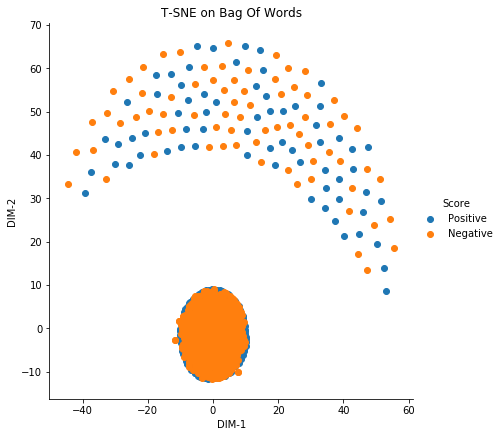

In [27]:
#plotting
tsne_data=np.vstack((tsne_data.T,scoresampledata)).T
tsnedf= pd.DataFrame(tsne_data,columns=('DIM-1','DIM-2','Score'))
sns.FacetGrid(tsnedf,hue='Score',height=6).map(plt.scatter,'DIM-1','DIM-2').add_legend()
plt.title('T-SNE on Bag Of Words')
plt.show()

* It looks like moon and star, but we can clearly see that points are overlapping
  and messy. And i tried using different perplexities

In [29]:
tsnedf.shape

(4000, 3)

# Text to vector using TF-IDF

In [30]:
connection= sqlite3.connect('final1.sqlite')
finaldata=pd.read_sql_query('''
SELECT * FROM Reviews
''',connection)
finaldata.shape

(364171, 12)

In [32]:
positivedata=finaldata[finaldata['Score']=='Positive'].sample(n=2000)
negativedata=finaldata[finaldata['Score']=='Negative'].sample(n=2000)
finalsampledata=pd.concat([positivedata,negativedata])
scoresampledata=finalsampledata['Score'].copy()
scoresampledata.shape

(4000,)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
model=TfidfVectorizer(ngram_range=(1,2))
tfidfdata= model.fit_transform(finalsampledata['CleanedText'].values)
tfidfdata.shape

(4000, 114670)

In [35]:
type(tfidfdata)

scipy.sparse.csr.csr_matrix

In [37]:
tfidfdata=tfidfdata.todense()

In [38]:
#standardizing
std_data= StandardScaler(with_mean=False).fit_transform(tfidfdata)

model= TSNE(n_components=2, random_state=0)
tsne_data= model.fit_transform(std_data)

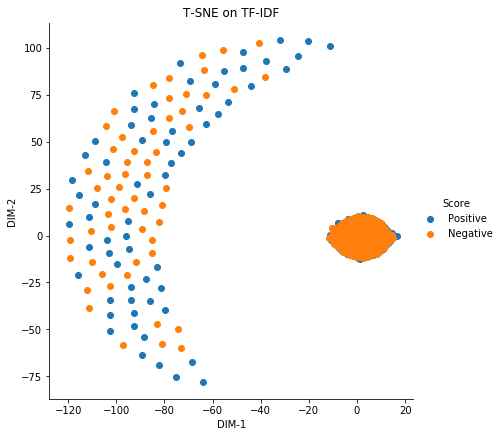

In [41]:
#plotting
tsne_data=np.vstack((tsne_data.T,scoresampledata)).T
tsnedf= pd.DataFrame(tsne_data,columns=('DIM-1','DIM-2','Score'))
sns.FacetGrid(tsnedf,hue='Score',height=6).map(plt.scatter,'DIM-1','DIM-2').add_legend()
plt.title('T-SNE on TF-IDF')
plt.show()

* This plot is approx same as previous one, points are overlapping and chaotic

# Text to vector using Word2Vec

In [4]:
#getting saved data from database
connection= sqlite3.connect('final1.sqlite')
finaldata=pd.read_sql_query('''
SELECT * FROM Reviews
''',connection)
finaldata.shape
positivedata=finaldata[finaldata['Score']=='Positive'].sample(n=2000)
negativedata=finaldata[finaldata['Score']=='Negative'].sample(n=2000)
finalsampledata=pd.concat([positivedata,negativedata])
scoresampledata=finalsampledata['Score'].copy()
scoresampledata.shape

(4000,)

In [15]:
# splitting sentence into list of words and storing in bigger list
i=0
lists=[]
for sent in finalsampledata['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    lists.append(filtered_sentence)

## Here i am making my own model using gensim inplace of using google

In [6]:
w2v_model= gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)
print(len(list(w2v_model.wv.vocab)))

33656


In [12]:
w2v_model.wv['tasty']

array([ 2.779757  ,  3.2179794 ,  2.8968503 , -0.47904578, -0.2565415 ,
        0.09560744, -0.1843421 ,  1.7362965 ,  0.7435667 ,  0.46188903,
       -1.4064106 , -0.41330507, -1.3160715 , -2.2556622 ,  1.2310809 ,
        1.0261742 , -1.5533592 ,  0.37728658, -0.15665089,  0.8026169 ,
        0.49638537,  1.0797148 , -2.2969012 ,  0.89900804, -5.321976  ,
       -1.7281448 , -2.9355476 , -1.3612206 ,  1.81525   ,  2.9553773 ,
       -2.066755  ,  4.1429515 , -1.5166917 ,  1.277844  , -0.1480974 ,
        1.8298144 ,  1.975031  , -0.6726055 , -2.4837933 , -3.9375095 ,
        3.767499  ,  1.5508816 , -1.4914491 ,  0.04430581, -0.19667168,
       -3.601849  ,  3.4427643 , -1.8672012 , -1.7577671 ,  2.6425364 ],
      dtype=float32)

In [71]:
w2v_model.wv.most_similar('tasty')

[('tastey', 0.9079850912094116),
 ('yummy', 0.856356143951416),
 ('satisfying', 0.847798228263855),
 ('delicious', 0.8157210350036621),
 ('filling', 0.8072576522827148),
 ('flavorful', 0.7884161472320557),
 ('versatile', 0.7524584531784058),
 ('nutritious', 0.7501760721206665),
 ('addicting', 0.7492634057998657),
 ('hardy', 0.7477256655693054)]

In [45]:
#average w2v 
sent_vectors= []
for sent in lists:
    sent_vec= np.zeros(50)
    cnt_words =0
    for words in sent:
        try:
            vec= w2v_model.wv[words]
            sent_vec +=vec
            cnt_words +=1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


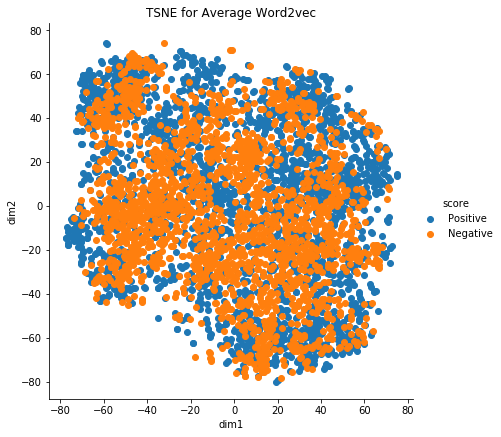

In [47]:
#plotting 
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, scoresampledata)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

* points here are very chaotic and overlapping

# Text to vector using TF-IDF weighted Word2Vec

In [ ]:
# making tfidf vector
tf_idf_vect= TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_idf_vect.fit_transform(finalsampledata['CleanedText'].values)
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors=[]
row=0

In [ ]:
# combining tfidf vector and w2v and making sentence vector
for sent in lists:
    sent_vec= np.zeros(50)
    weight_sum =0
    for word in sent:
        try:
            vec= w2v_model.wv[word]
            tfidf = final_tf_idf[row,tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row +=1

In [39]:
tfidf_sent_vectors=np.nan_to_num(tfidf_sent_vectors)

In [ ]:
#modeling tsne
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, scoresampledata)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

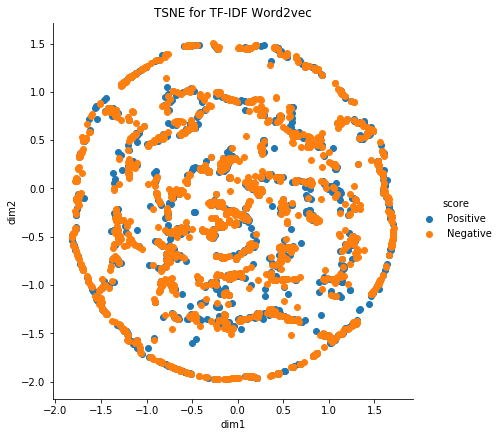

In [72]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", height=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

* In Tsne plots of [BOW, TFIDF, avg w2v, avg TFIDF weighted w2v] , positive and negative
  points are not well seperated they are overlapping each other
* From above we can say TSNE visualization was not valuable because we cannot see 
  seperated sentiments (positive and negative). We cannot make a line or other 
  curves to seperate the classes